In [1]:
import os
import keras
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
SEED = 68857869
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Dataset Download and Preparation

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip
!mkdir images
!find /content/tiny-imagenet-200 -type f -name '*.JPEG' -exec mv {} /content/images \;
!ls images | wc -l
!mkdir -p cache

### Data Loading and Preprocessing

In [ ]:
def decode_img(img,img_width,img_height):
  img = tf.io.read_file(img)
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [img_width,img_height])


def datapipe(files,batch_size,img_width,img_height,name):
  cover = tf.data.Dataset.from_tensor_slices(files)
  cover = cover.map(lambda x: decode_img(x,img_width,img_height))

  payload = tf.data.Dataset.from_tensor_slices(files)
  payload = payload.map(lambda x: decode_img(x,img_width,img_height))

  data = tf.data.Dataset.zip(cover,payload)
  ds = tf.data.Dataset.zip(data,data)

  ds = ds.batch(batch_size).cache(f'./cache/dataset-{name}-{batch_size}-{img_width}-{img_height}')
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds


files       = [f"images/{_file}" for _file in os.listdir('images')]
train , val = train_test_split(files,train_size=0.7)

batch_size=32

train = datapipe(train,batch_size,64,64,'train')
val   = datapipe(val,batch_size,64,64,'val')

(32, 64, 64, 3)


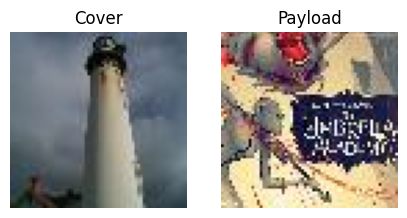

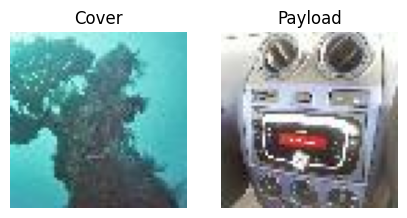

In [ ]:
for target,predict in train_dataset.take(1):
    cover = target[0][0].numpy().astype("uint8")
    payload = target[1][0].numpy().astype("uint8")

    fig, ax = plt.subplots(1, 2, figsize=(5, 3))

    ax[0].imshow(cover)
    ax[0].set_title('Cover')
    ax[0].axis('off')

    ax[1].imshow(payload)
    ax[1].set_title('Payload')
    ax[1].axis('off')

    plt.show()

    cover = predict[0][0].numpy().astype("uint8")
    payload = predict[1][0].numpy().astype("uint8")

    fig, ax = plt.subplots(1, 2, figsize=(5, 3))

    ax[0].imshow(cover)
    ax[0].set_title('Cover')
    ax[0].axis('off')

    ax[1].imshow(payload)
    ax[1].set_title('Payload')
    ax[1].axis('off')

    plt.show()

### Model Definition

In [ ]:
def conv_layer(x, num_filters, activation='relu', name='conv_layer'):
    x = keras.layers.Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv')(x)
    x = keras.layers.BatchNormalization(name=f'{name}_bn')(x)
    x = keras.layers.Activation(activation, name=f'{name}_act')(x)
    return x

def encoder():
    cover_input = keras.Input(shape=(64, 64, 3), name='cover_input')
    payload_input = keras.Input(shape=(64, 64, 3), name='payload_input')

    conc_layer = keras.layers.Concatenate(name='concat_cover_payload')([cover_input, payload_input])

    l1 = conv_layer(conc_layer, 64, name='encoder_l1')
    l2 = conv_layer(l1, 128, name='encoder_l2')
    l3 = conv_layer(l2, 256, name='encoder_l3')
    l4 = conv_layer(l3, 512, name='encoder_l4')
    l5 = conv_layer(l4, 512, name='encoder_l5')

    x = keras.layers.Concatenate(name='concat_l3_l5')([l3, l5])
    l6 = conv_layer(x, 256, name='encoder_l6')

    x = keras.layers.Concatenate(name='concat_l2_l6')([l2, l6])
    l7 = conv_layer(x, 128, name='encoder_l7')

    x = keras.layers.Concatenate(name='concat_l1_l7')([l1, l7])
    l8 = conv_layer(x, 64, name='encoder_l8')

    steg_image = conv_layer(l8, 3, activation='sigmoid', name='encoder_output')

    encoder_model = keras.Model(inputs=[cover_input, payload_input], outputs=steg_image, name='encoder')
    return encoder_model

def decoder():
    steg_input = keras.layers.Input(shape=(64, 64, 3), name='steg_image_input')
    x = conv_layer(steg_input, 64, name='decoder_l1')
    x = conv_layer(x, 128, name='decoder_l2')
    x = conv_layer(x, 256, name='decoder_l3')
    x = conv_layer(x, 128, name='decoder_l4')
    x = conv_layer(x, 64, name='decoder_l5')
    x = conv_layer(x, 3, activation='sigmoid', name='decoder_output')

    decoder_model = keras.Model(inputs=steg_input, outputs=x, name='decoder')
    return decoder_model

In [ ]:
cover_input = keras.Input(shape=(64, 64, 3), name='cover_input')
payload_input = keras.Input(shape=(64, 64, 3), name='payload_input')

encoder_model = encoder()
decoder_model = decoder()

steg_image    = encoder_model([cover_input, payload_input])
payload_image = decoder_model(steg_image)

model = keras.Model(inputs=[cover_input, payload_input], outputs=[steg_image,payload_image], name='steg_model')
model.summary()

Model: "steg_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cover_input (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ payload_input             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ (None, 64, 64, 3)      │      6,244,815 │ cover_input[0][0],     │
│                           │                        │                │ payload_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 64, 64, 3)      │        743,951 │ encoder[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,988,766 (26.66 MB)

 Trainable params: 6,983,634 (26.64 MB)

 Non-trainable params: 5,132 (20.05 KB)

### Loss functions

In [ ]:
beta = 0.9

def steg_loss(true,pred):
  steg_true,payload_true = true
  steg_pred,payload_pred = pred

  l1 = keras.losses.mean_squared_error(steg_true,steg_pred)
  l2 = keras.losses.mean_squared_error(payload_true,payload_pred)

  return l1+(beta*l2)

### Training


In [ ]:
model.compile(optimizer='adam', loss=steg_loss)

In [ ]:
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


ValueError: Layer "steg_model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 64, 64, 3) dtype=float32>]